In [20]:
import os
import json
import yaml
import torch
import random
import detectron2

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [21]:
# Verify GPU information
print (torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.device(0)
       , torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional info when using CUDA
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

True 1 0 <torch.cuda.device object at 0x155437cfda30> NVIDIA A30
Using device: cuda

NVIDIA A30
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [22]:
# Indicate to D2 how to read dataset if not in coco format:

def get_dataset_dicts(img_dir):
    """Function that tells detectron2 know how to obtain a custom datasets by specifying it similarly to COCO’s annotations: see https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html 

    Args:
        img_dir (str): path to the directory containing the images and annotations .json file 

    Returns:
        list: list of dictionaries containing the information of the dataset
    """
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)
    
    dataset_dicts = []
    for idx, annots in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, annots["filename"])
        height, width = cv.imread(filename).shape[:2]
        
        #Info on the tile .png file
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        #info on annotation
        annotations = annots["regions"]
        objs = []
        for _, anno in annotations.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px),
                         np.min(py),
                         np.max(px),
                         np.max(py)
                        ],
                #XYXY_ABS: https://detectron2.readthedocs.io/en/latest/_modules/detectron2/structures/boxes.html
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": anno["category"]
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

classes = ["asset"]
colors = [(249, 180, 45)]

#Register dataset and metadata
for d in ["train", "val"]:
    DatasetCatalog.register(d, lambda d=d: get_dataset_dicts(os.path.join("../NSO", d)))
    # Key-value mappingto interpret what’s in the dataset: names of classes, colors of classes
    MetadataCatalog.get(d).thing_classes = classes
    MetadataCatalog.get(d).thing_colors = colors

AssertionError: Dataset 'train' is already registered!

../NSO/train/10_20220719_105318_SV1-04_SV_RD_8bit_RGB_50cm_Heel_27000_11000.png


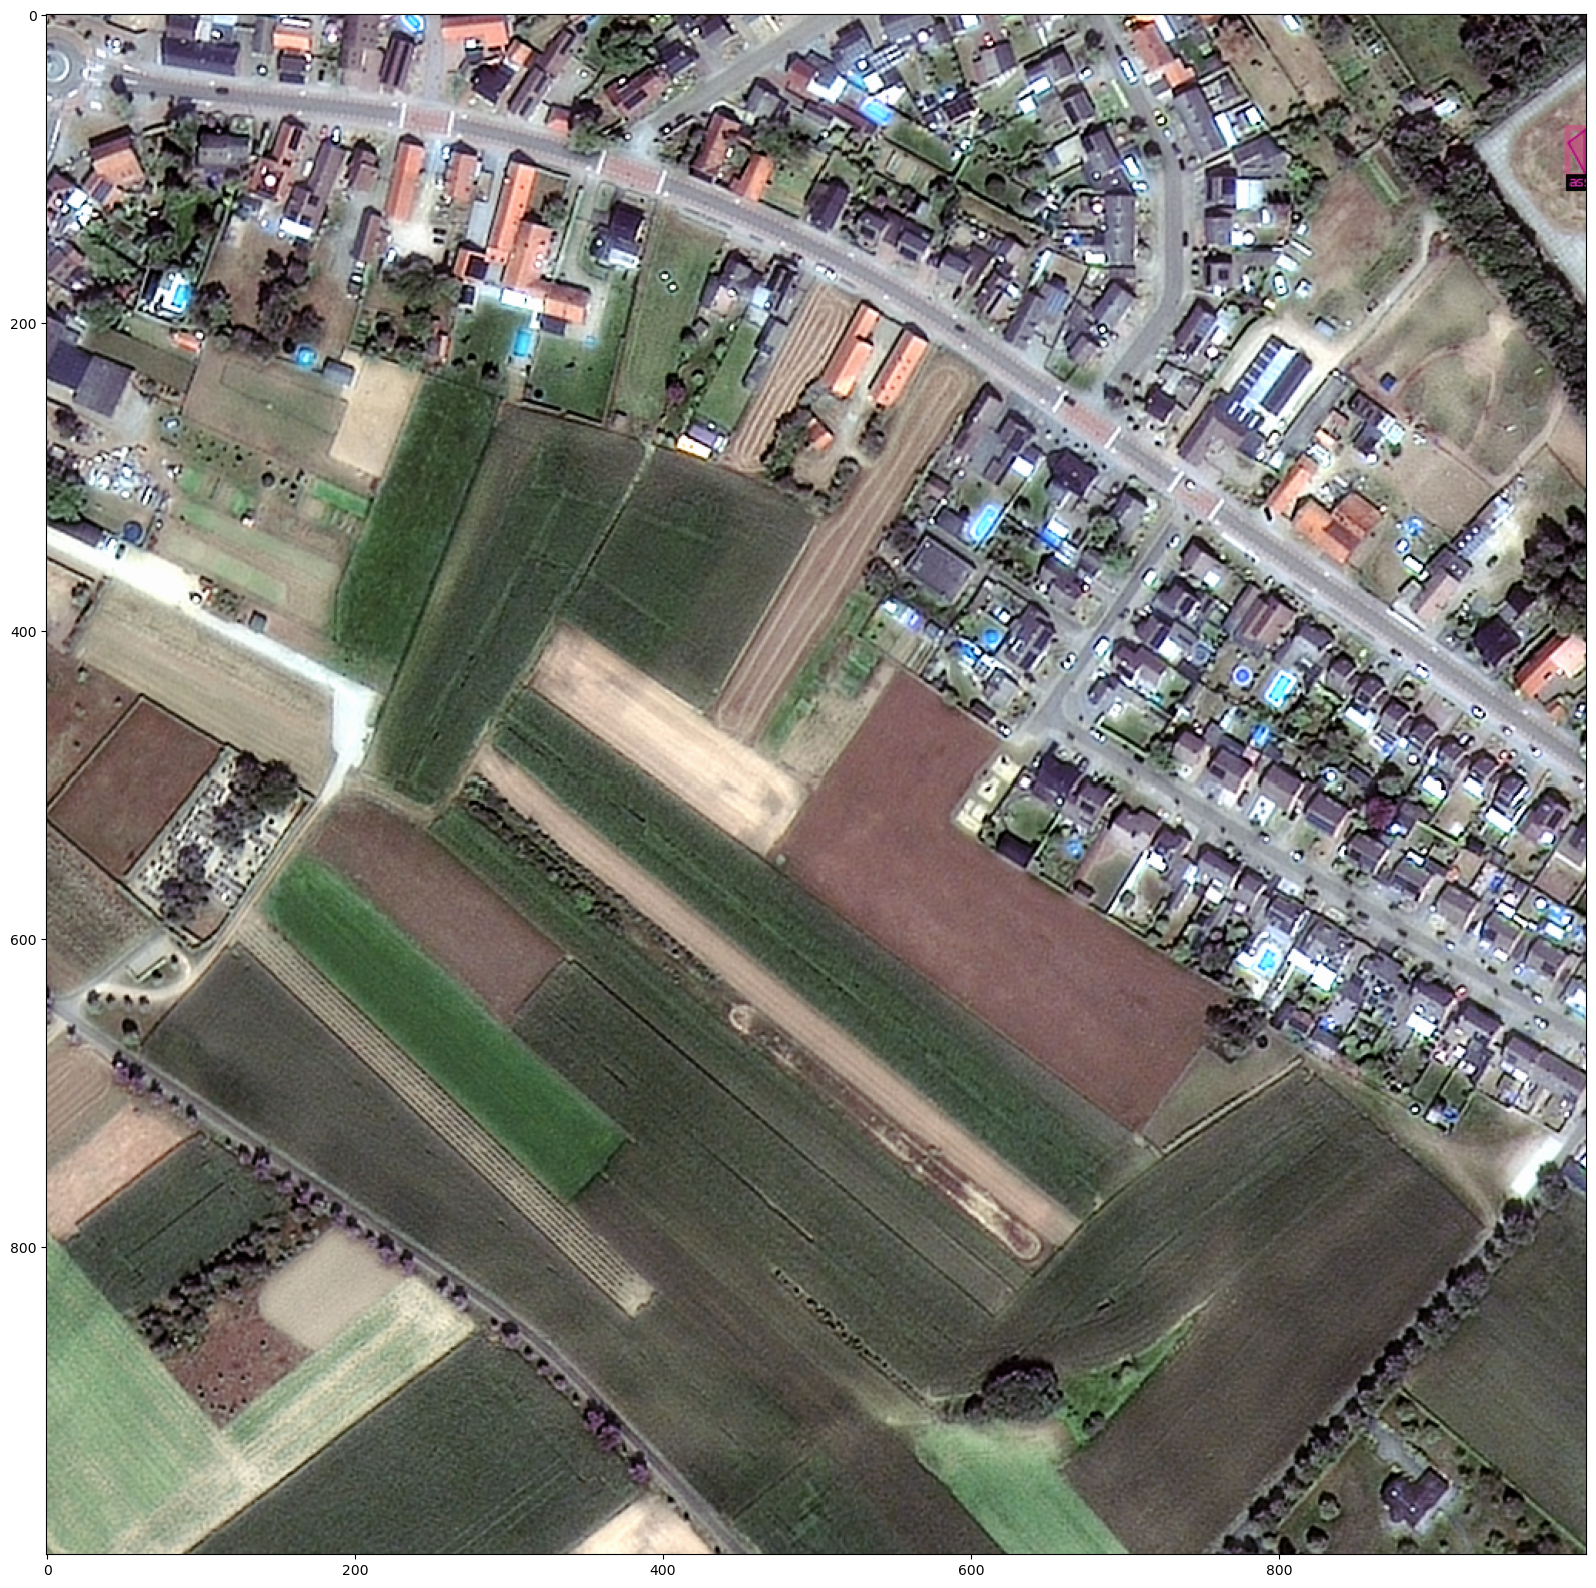

In [8]:
# Visualise annotations of trainning dataset

metadata = MetadataCatalog.get("train")
dataset_dicts = get_dataset_dicts("../NSO/train")

for d in random.sample(dataset_dicts, 1):
    img = cv.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1, instance_mode=ColorMode.IMAGE)
    out = visualizer.draw_dataset_dict(d)
    print(d["file_name"])
    plt.figure(figsize=(20, 20))
    #plt.imshow(out.get_image()[:, :, ::-1])#BGR to RGB
    plt.imshow(out.get_image()[:, :, :])
    plt.show()

../NSO/val/8_20221009_105642_SV1-04_SV_RD_8bit_RGB_50cm_Lunteren_27000_1000.png


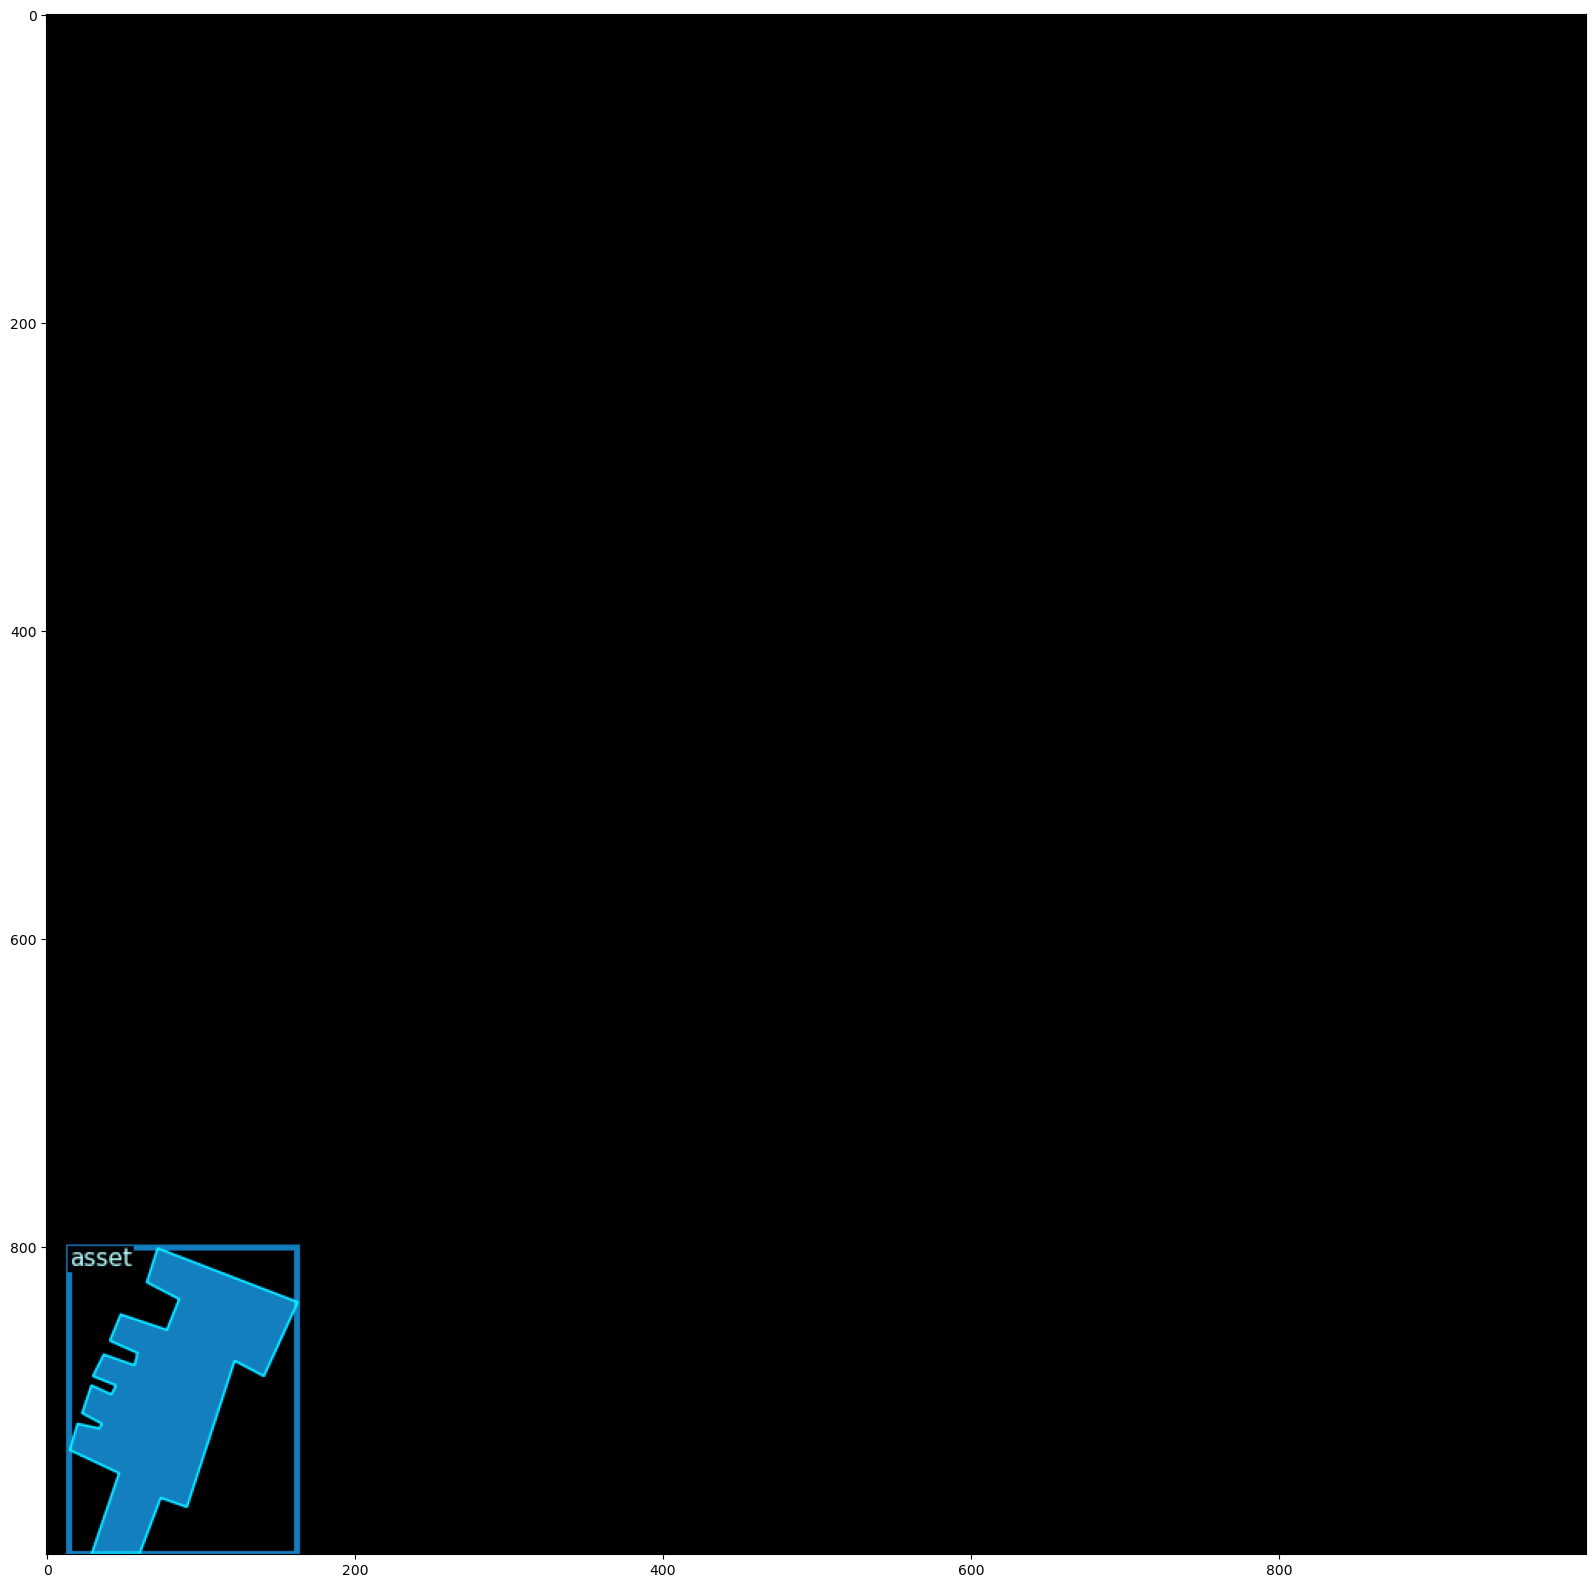

In [23]:
# Visualise annotations of validation dataset

metadata = MetadataCatalog.get("val")
dataset_dicts = get_dataset_dicts("../NSO/val")

for d in random.sample(dataset_dicts, 1):
    img = cv.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1, instance_mode=ColorMode.IMAGE)
    out = visualizer.draw_dataset_dict(d)
    print(d["file_name"])
    plt.figure(figsize=(20, 20))
    #plt.imshow(out.get_image()[:, :, ::-1])#BGR to RGB
    plt.imshow(out.get_image()[:, :, :])
    plt.show()

In [10]:
# Setting up model configugation for training

# initializes an empty config
cfg = get_cfg()

# add custom component to configuration
# load values from API: https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
#https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
cfg.DATASETS.TEST = ("val",) # should not be set for training: https://github.com/facebookresearch/detectron2/issues/951
# initiate weights from model zoo
# check points (.pth) = model's parameters and optimizer state to resume training or evalate performance
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")
# set learning rate
cfg.SOLVER.BASE_LR = 0.005
# Dataloader provides data to the model
# Load data to GPU: the more data you put into the GPU memory, the less memory is available for the model (4 in Spacenet)
# https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/33?page=2
# https://stackoverflow.com/questions/53998282/how-does-the-number-of-workers-parameter-in-pytorch-dataloader-actually-work
# Cluster warning: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2
cfg.DATALOADER.NUM_WORKERS = 2
# real batch size:  number of training examples utilized in one iteration.
cfg.SOLVER.IMS_PER_BATCH = 4
# parameter  used to sample a subset of proposals coming out of RPN to calculate cls and reg loss during training
# "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512). Spacenet uses 16 for 4 GPUs 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 16
# Number of class = 1 (1 asset Type)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# config not included SPACENET
# adjust up if val mAP is still rising, adjust down if overfit/ 300 iterations seems good for toy dataset
cfg.SOLVER.MAX_ITER = 50    
# [] => do not decay learning rate
#configuration specifies the iteration steps at which the learning rate is decreased during training.
#cfg.SOLVER.STEPS = []
#cfg.SOLVER.WARMUP_ITERS = 1000
#cfg.SOLVER.GAMMA = 0.05
#number of itteration after wich the validation set is used for evaluation
#cfg.TEST.EVAL_PERIOD = 25 


# Directory for (logs, configs, metrics, and model checkpoints)
#cfg.OUTPUT_DIR = "../NSO/output
cfg.OUTPUT_DIR = "../NSO/output_40tiles_005LR_4B_50iter"
# print configs 
print(cfg.dump())

# Save your configurations for multi-GPU use
with open("../NSO/NSOD2cfg_40tiles_005LR_4B_50iter.yaml", "w") as file:
    yaml.dump(cfg, file)

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - val
  TRAIN:
  - train
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  D

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

In [ ]:
#AFTER TRAINING 1: Check if both work
#https://github.com/rl02898/detectron2-spacenet/blob/master/detectron_demo.py

# Inference configurations
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Overwriting configs for inference
with open("../NSO/NSOD2cfg_40tiles_005LR_4B_50iter.yaml", "w") as file:
    yaml.dump(cfg, file)

In [25]:
#AFTER TRAINING 2: : Check if both work
#https://russland.medium.com/using-detectron2-for-instance-segmentation-on-the-spacenet-dataset-94338f739cd0

# Inference configurations
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get("train")

# Overwriting configs for inference
with open("../NSO/NSOD2cfg_40tiles_005LR_4B_50iter.yaml", "w") as file:
    yaml.dump(cfg, file)